In [1]:
import numpy as np
import pandas as pd
import geojson
import matplotlib.pyplot as plt
from __future__ import division
from collections import Counter
from operator import itemgetter
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

%matplotlib inline

In [2]:
#Load the data
data_socio = pd.read_csv('samlede_socio_data_kbh.csv', encoding = 'utf8')

In [4]:
#Load the geo data such that the clusters can be added to it.
with open('../CPH-social-data-analysis/geodata.geojson') as f:
    data = geojson.load(f)

In [5]:
#Get a list of the years. Don't use 2014 since it's data is bad.
yearlist=list(set(data_socio['aar']))
yearlist=yearlist[0:-1]
#Define the features that are used for clustering.
clusterlist=['pct_lav_indkomst','pct_middel_indkomst','pct_hoj_indkomst','pct_dansk','antal_boliger','antal_beboere',
                 'bolig_pct_over_120_m2','alder_pct_over_65']

In [6]:
#Cluster for all the years.
for year in yearlist:
    MLdf=data_socio[clusterlist][data_socio['aar']==year]
    #Deal with NaN's
    nonanmat=MLdf
    nanlist=np.argwhere(np.isnan(nonanmat.as_matrix()))
    namelist=list(nonanmat)
    #Set all nans to the mean of the column
    for x in nanlist:
        nonanmat.set_value(nonanmat.iloc[[x[0]]].index[0],namelist[x[1]] , np.mean(nonanmat[namelist[x[1]]]))
    #Now only columns with pure NaN's remain in the df. Remove those leaving only the good data.
    nonanmat=nonanmat.dropna(axis=1)
    
    #Define X
    X=nonanmat.as_matrix()
    #Standardize the data
    stand=StandardScaler(copy=True, with_mean=True, with_std=True)
    X=stand.fit_transform(X)
    
    #Run the K-means algorithm
    KMalg=KMeans(n_clusters=4, init='k-means++', n_init=100, max_iter=500, tol=0.0001, precompute_distances='auto',
       verbose=0, random_state=None, copy_x=True, n_jobs=1)
    #Fit the K-means
    KMfit=KMalg.fit_predict(X)
    
    #Append the cluster number to the geo data such that they can be plotted on the website.
    rodelist=data_socio['rode_nr'][data_socio['aar']==year].tolist()
    for i in range(len(data['features'])):
        rodnum=data['features'][i]['properties']['rode_nr']
        if rodnum in rodelist:
            idx=rodelist.index(rodnum)
            data['features'][i]['properties'][str(year)]['cluster']=KMfit[idx]+1
        else:
            #If the rode is missing, just set the cluster to -1
            data['features'][i]['properties'][str(year)]['cluster']=-1

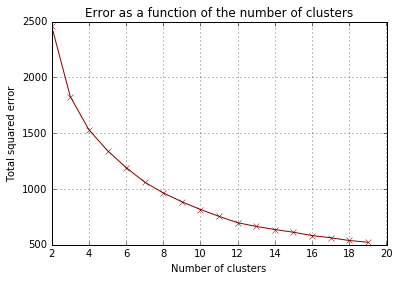

In [7]:
#Try to find the best sutiable K when doing K-means.
#This was investigated before the code above was run.
K = range(2,20)

#Creating empty dict and array for model and squared errors
modelKM = {}
sqErr = []

for k in K:
    estimator = KMeans(init='k-means++', n_clusters=k, n_init=10)
    modelKM[k] = estimator.fit(X)
    sqErr.append(modelKM[k].inertia_)
    
plt.plot(K,sqErr, color='darkred',marker="x") # add a title
plt.title("Error as a function of the number of clusters")
plt.ylabel("Total squared error")
plt.xlabel("Number of clusters")

plt.grid(True)
plt.show()

In [17]:
#Save the geodata with the clustering numbers to a new data set.
with open('../CPH-social-data-analysis/geodata_clustering.geojson', 'w') as outfile:
    geojson.dump(data, outfile)